In [26]:
import os
# Change to the cloned repo directory (optional)
%cd '/content/spotify-listening-data'
for dirname, _, filenames in os.walk('/content/spotify-listening-data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/spotify-listening-data
/content/spotify-listening-data/README.md
/content/spotify-listening-data/data/raw/Streaming_History_Audio_2013-2024.json
/content/spotify-listening-data/data/processed/spotify_data.csv
/content/spotify-listening-data/.git/config
/content/spotify-listening-data/.git/index
/content/spotify-listening-data/.git/HEAD
/content/spotify-listening-data/.git/packed-refs
/content/spotify-listening-data/.git/description
/content/spotify-listening-data/.git/hooks/post-update.sample
/content/spotify-listening-data/.git/hooks/update.sample
/content/spotify-listening-data/.git/hooks/commit-msg.sample
/content/spotify-listening-data/.git/hooks/pre-push.sample
/content/spotify-listening-data/.git/hooks/fsmonitor-watchman.sample
/content/spotify-listening-data/.git/hooks/push-to-checkout.sample
/content/spotify-listening-data/.git/hooks/pre-rebase.sample
/content/spotify-listening-data/.git/hooks/applypatch-msg.sample
/content/spotify-listening-data/.git/hooks/prepare-com

# **MAIN FUNCTION TO UPDATE & SAVE MUSIC LIBRARY DATABASE**


In [ ]:
import requests
from base64 import b64encode
import os
from google.colab import userdata

# Step 1: Set up Spotify credentials as environment variables in Google Colab
CLIENT_ID = userdata.get('spotify_client_id')
CLIENT_SECRET = userdata.get('spotify_client_sec')

# Step 2: Get Access Token from Spotify API using Client Credentials Flow
def get_access_token(client_id, client_secret):
    auth_header = b64encode(f"{client_id}:{client_secret}".encode('utf-8')).decode('utf-8')
    headers = {
        'Authorization': f'Basic {auth_header}',
        'Content-Type': 'application/x-www-form-urlencoded'
    }
    data = {'grant_type': 'client_credentials'}

    response = requests.post('https://accounts.spotify.com/api/token', headers=headers, data=data)
    if response.status_code == 200:
        return response.json()['access_token']
    else:
        print("Failed to get access token")
        print(response.json())  # Added for better debugging
        return None

# Step 3: Search for a track by name and artist
def search_track(track_name, artist_name, access_token):
    headers = {'Authorization': f'Bearer {access_token}'}
    query = f"track:{track_name} artist:{artist_name}"
    params = {'q': query, 'type': 'track', 'limit': 1}

    response = requests.get('https://api.spotify.com/v1/search', headers=headers, params=params)
    if response.status_code == 200:
        results = response.json()
        if results['tracks']['items']:
            track = results['tracks']['items'][0]  # Get the first matching result
            return {
                'Track Name': track['name'],
                'Artist': track['artists'][0]['name'],
                'Album': track['album']['name'],
                'Release Date': track['album']['release_date'],
                'Duration (ms)': track['duration_ms'],
                'Popularity': track['popularity'],
                'URI': track['uri']
            }
        else:
            print("No track found")
            return None
    else:
        print("Failed to search for track")
        print(response.json())  # Added for better debugging
        return None


In [ ]:
# Step 4: Example usage - search for "Never Gonna Give You Up" by Rick Astley
access_token = get_access_token(CLIENT_ID, CLIENT_SECRET)
if access_token:
    track_info = search_track("Never Gonna Give You Up", "Rick Astley", access_token)
    if track_info:
        print(track_info)

{'Track Name': 'Never Gonna Give You Up', 'Artist': 'Rick Astley', 'Album': 'Whenever You Need Somebody', 'Release Date': '1987-11-12', 'Duration (ms)': 213573, 'Popularity': 78, 'URI': 'spotify:track:4PTG3Z6ehGkBFwjybzWkR8'}


# **MAIN FUNCTION TO UPDATE & SAVE TO DATABASE**
Set json_file_path to the name of the file you want to process.

In [ ]:
json_file_path = "/kaggle/input/music-data/data/raw/StreamingHistory_music_0.json"
json_to_csv(json_file_path)

Data successfully updated and saved to data/processed/spotify_data.csv


In [ ]:
import pandas as pd
import uuid
import os
import requests  # For ipstack API


def get_location_from_ip(ip_address):
    access_key = 'your_ipstack_api_key'
    url = f'http://api.ipstack.com/{ip_address}?access_key={access_key}'

    response = requests.get(url)
    location_data = response.json()

    if location_data.get("error"):
        print("Error in fetching location data")
        return None
    else:
        return {
            'country': location_data.get('country_name'),
            'region': location_data.get('region_name'),
            'city': location_data.get('city'),
            'latitude': location_data.get('latitude'),
            'longitude': location_data.get('longitude')
        }

def json_to_csv(json_file_path, csv_output_path='data/processed/spotify_data.csv'):
    # Load the new JSON data into a DataFrame
    new_data = pd.read_json(json_file_path)

    # Rename columns for consistency
    new_data.rename(columns={
        'ts': 'end_time_UTC',
        'platform': 'platform',
        'ms_played': 'ms_played',
        'conn_country': 'connection_country',
        'ip_addr_decrypted': 'ip_address',
        'master_metadata_track_name': 'track_name',
        'master_metadata_album_artist_name': 'album_artist_name',
        'master_metadata_album_album_name': 'album_name',
        'spotify_track_uri': 'track_uri',
        'episode_name': 'episode_name',
        'episode_show_name': 'episode_show_name',
        'spotify_episode_uri': 'episode_uri',
        'reason_start': 'start_reason',
        'reason_end': 'end_reason',
        'shuffle': 'shuffle',
        'skipped': 'skipped',
    }, inplace=True)

    # Get the location data and normalize it into separate columns
    location_data = new_data['ip_address'].apply(lambda ip: get_location_from_ip(ip))

    # Normalize the location data into separate columns
    location_df = json_normalize(location_data)

    # Merge the location data with the original DataFrame
    new_data = pd.concat([new_data, location_df], axis=1)

    # Generate a unique ID for each row
    new_data['unique_id'] = new_data['end_time_UTC'].apply(lambda x: f"{x}_{uuid.uuid4().hex[:8]}")

    # Keep only the relevant columns for the CSV
    new_data = new_data[['unique_id', 'end_time_UTC', 'platform', 'ms_played', 'connection_country',
                         'ip_address', 'track_name', 'album_artist_name', 'album_name',
                         'track_uri', 'episode_name', 'episode_show_name', 'episode_uri',
                         'start_reason', 'end_reason', 'shuffle', 'skipped',
                         'country', 'region', 'city', 'latitude', 'longitude']]

    # If the output CSV already exists, read it to check for duplicates
    if os.path.exists(csv_output_path):
        existing_data = pd.read_csv(csv_output_path)

        # Identify and keep only new rows that are not already in the CSV
        merged_data = pd.concat([existing_data, new_data]).drop_duplicates(subset=['unique_id'], keep='first')
    else:
        # If no existing CSV, just use new data
        merged_data = new_data

    # Ensure the 'processed' directory exists (create it if not)
    os.makedirs(os.path.dirname(csv_output_path), exist_ok=True)

    # Save updated data to CSV in the specified path
    merged_data.to_csv(csv_output_path, index=False)

    print(f"Data successfully updated and saved to {csv_output_path}")

In [ ]:
# Load your CSV file (ensure you have the correct file path)
csv_file_path = '/kaggle/input/musicdata/data/processed/spotify_data.csv'

# Load the dataset into a pandas DataFrame
df = pd.read_csv(csv_file_path)

# Display the first few rows of the DataFrame to understand its structure
df

,unique_id,end_time,artist_name,track_name,ms_played
0,2024-10-31_12:50_68c75648,2024-10-31 12:50,Charli xcx,Boom Clap,169866
1,2024-10-31_12:52_41a32308,2024-10-31 12:52,Bob's Burgers,Beyond the Sea,135277
2,2024-10-31_12:54_282a2c47,2024-10-31 12:54,Glee Cast,I Say A Little Prayer (Glee Cast Version),100813
3,2024-10-31_12:56_4ab98dfa,2024-10-31 12:56,Bob's Burgers,Not the Forgiving Type,120638
4,2024-10-31_13:08_7dddf515,2024-10-31 13:08,Bob's Burgers,The Forgiving Type,35336
...,...,...,...,...,...
10513,2024-10-31_12:36_5ab375f2,2024-10-31 12:36,RuPaul,Cha Cha Bitch (feat. AB Soto),213600
10514,2024-10-31_12:39_fce81ee9,2024-10-31 12:39,Miranda Cosgrove,Kissin U,199693
10515,2024-10-31_12:41_3ca879a6,2024-10-31 12:41,Bob's Burgers,Nothing Makes Me Happy,101647
10516,2024-10-31_12:46_0f061053,2024-10-31 12:46,Justin Bieber,As Long As You Love Me,198826


In [ ]:
# Convert 'end_time' to datetime
df['end_time'] = pd.to_datetime(df['end_time'], format='%Y-%m-%d %H:%M')

# Verify the conversion
df['end_time'].head()


0   2024-10-31 12:50:00
1   2024-10-31 12:52:00
2   2024-10-31 12:54:00
3   2024-10-31 12:56:00
4   2024-10-31 13:08:00
Name: end_time, dtype: datetime64[ns]

In [ ]:
def most_listened_artists(df, top_n=10):
    # Count the number of times each artist appears in the dataset
    artist_counts = df['artist_name'].value_counts().head(top_n)
    return artist_counts

top_artists = most_listened_artists(df)
print(top_artists)

artist_name
Unknown Artist              612
Crazy Ex-Girlfriend Cast    451
Lady Gaga                   194
Bob's Burgers               193
RuPaul                      175
Dai                         167
Nicki Minaj                 152
Britney Spears              152
Katy Perry                  145
Chappell Roan               139
Name: count, dtype: int64


In [ ]:
def most_played_tracks(df, top_n=10):
    # Count the number of times each track is played
    track_counts = df['track_name'].value_counts().head(top_n)
    return track_counts

top_tracks = most_played_tracks(df)
print(top_tracks)


track_name
Unknown Track        612
Genie In a Bottle     84
TiK ToK               38
Toxic                 36
Timber                32
Femininomenon         28
By the Sea            27
Pink Pony Club        25
Rush                  24
Poker Face            24
Name: count, dtype: int64


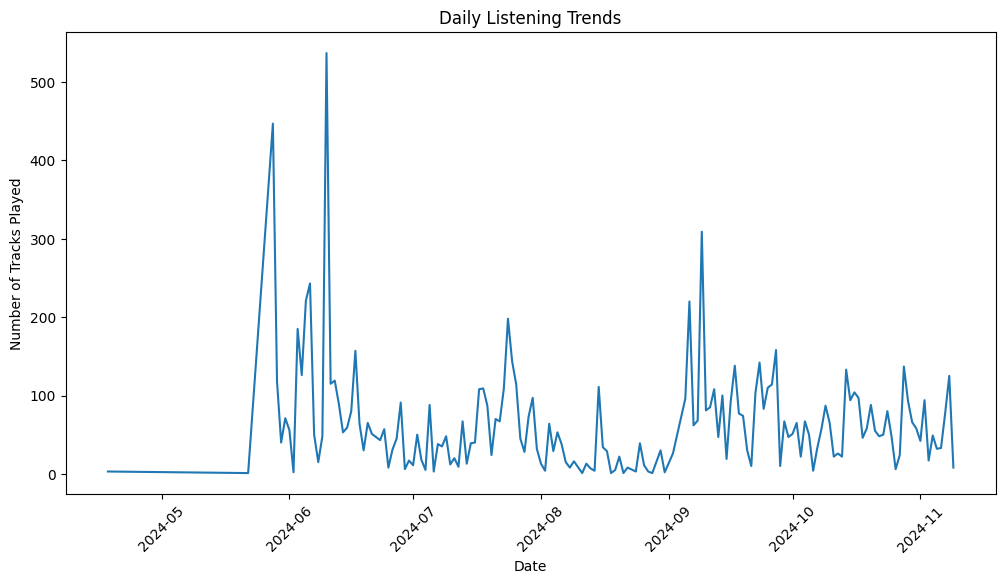

In [ ]:
import matplotlib.pyplot as plt

def listening_trends(df):
    # Group by date and count the number of tracks played each day
    df['date'] = df['end_time'].dt.date
    daily_listening = df.groupby('date').size()

    # Plot the trends
    plt.figure(figsize=(12, 6))
    daily_listening.plot(kind='line')
    plt.title('Daily Listening Trends')
    plt.xlabel('Date')
    plt.ylabel('Number of Tracks Played')
    plt.xticks(rotation=45)
    plt.show()

listening_trends(df)

In [ ]:
def clean_unknown_entries(df):
    # Filter out rows where track or artist is 'Unknown'
    cleaned_df = df[~df['track_name'].str.contains('Unknown', case=False, na=False)]
    cleaned_df = cleaned_df[~df['artist_name'].str.contains('Unknown', case=False, na=False)]

    # Optionally, return a separate DataFrame for "Unknown" entries if you want to analyze them
    unknown_entries = df[df['track_name'].str.contains('Unknown', case=False, na=False) | df['artist_name'].str.contains('Unknown', case=False, na=False)]

    return cleaned_df, unknown_entries

cleaned_df, unknown_entries = clean_unknown_entries(df)

# Display cleaned data and unknown entries
print(f"Cleaned Data (first 5 rows):\n{cleaned_df.head()}")
print(f"Unknown Entries (first 5 rows):\n{unknown_entries.head()}")

Cleaned Data (first 5 rows):
                   unique_id            end_time    artist_name  \
0  2024-10-31_12:50_68c75648 2024-10-31 12:50:00     Charli xcx   
1  2024-10-31_12:52_41a32308 2024-10-31 12:52:00  Bob's Burgers   
2  2024-10-31_12:54_282a2c47 2024-10-31 12:54:00      Glee Cast   
3  2024-10-31_12:56_4ab98dfa 2024-10-31 12:56:00  Bob's Burgers   
4  2024-10-31_13:08_7dddf515 2024-10-31 13:08:00  Bob's Burgers   

                                  track_name  ms_played        date  
0                                  Boom Clap     169866  2024-10-31  
1                             Beyond the Sea     135277  2024-10-31  
2  I Say A Little Prayer (Glee Cast Version)     100813  2024-10-31  
3                     Not the Forgiving Type     120638  2024-10-31  
4                         The Forgiving Type      35336  2024-10-31  
Unknown Entries (first 5 rows):
                     unique_id            end_time     artist_name  \
343  2024-11-07_19:12_38074bd2 2024-11-07 19:1

/tmp/ipykernel_30/1511602440.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cleaned_df = cleaned_df[~df['artist_name'].str.contains('Unknown', case=False, na=False)]


In [ ]:
def identify_skipped_songs(df, skip_threshold=0.3):
    # If you had track lengths, you could compare `ms_played` to track lengths (in ms).
    # For now, we'll use a general approach based on how much was played.

    # Find tracks that have been played for less than `skip_threshold` percentage
    skipped_songs = df[df['ms_played'] < df['ms_played'].max() * skip_threshold]

    # Count how often each track appears in the skipped songs
    skipped_song_counts = skipped_songs['track_name'].value_counts()

    return skipped_song_counts

skipped_songs = identify_skipped_songs(cleaned_df)
print(f"Skipped Songs (played less than 30%):\n{skipped_songs.head()}")

Skipped Songs (played less than 30%):
track_name
Genie In a Bottle    70
Rush                 24
Karma                24
Espresso             21
I Kissed A Girl      21
Name: count, dtype: int64


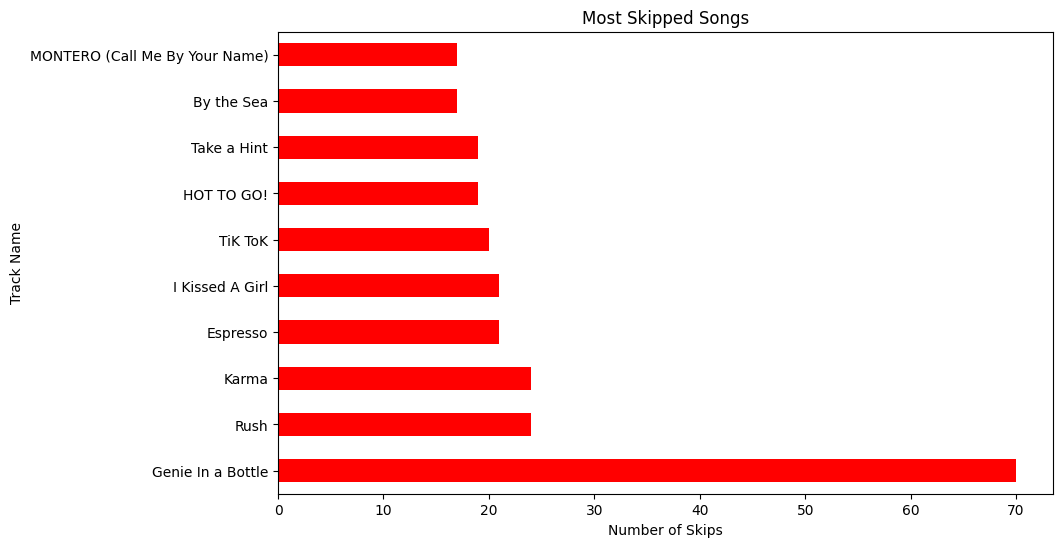

In [ ]:
def plot_skipped_songs(skipped_song_counts, top_n=10):
    # Plot the top N skipped songs as a bar chart
    skipped_song_counts.head(top_n).plot(kind='barh', figsize=(10, 6), color='red')
    plt.title('Most Skipped Songs')
    plt.xlabel('Number of Skips')
    plt.ylabel('Track Name')
    plt.show()

plot_skipped_songs(skipped_songs)